# 4 Heterogeneous Agents 
Consider the environment in section 5. We need to solve the following:
\begin{align*}
    \begin{split}
    {L}^e_{HJB} \left(v^e, v^h, \kappa, \chi;x \right) &= \frac{\rho_e}{1-\rho_e} \delta_e^{1 / \rho_e} \exp\left[({1- \frac{1}{\rho_e}})v^e)\right]-\frac{\delta_e}{1-\rho_e}+r\\&+\frac{1}{2 \gamma_e} \frac{\left(\Delta^e+\pi^h \cdot \sigma_R\right)^2}{\left\|\sigma_R\right\|^2}
+\left[\mu_X+\frac{1-\gamma_e}{\gamma_e}\left(\frac{\Delta^e+\pi^h \cdot \sigma_R}{\left\|\sigma_R\right\|^2}\right) \sigma_X \sigma_R\right] \cdot \partial_X v^e \\
&+\frac{1}{2}\left[\operatorname{tr}\left(\sigma_X^{\prime} \partial_{xx^{\prime}} v^e \sigma_X\right)+\frac{1-\gamma_e}{\gamma_e}\left(\sigma_X^{\prime} \partial_x v_e\right)^{\prime}\left[\gamma_e \mathbb{I}_d+\left(1-\gamma_e\right) \frac{\sigma_R \sigma_R^{\prime}}{\left\|\sigma_R\right\|^2}\right] \sigma_X^{\prime} \partial_x v^e\right]= 0 
\end{split}\\
\begin{split}
    {L}^h_{HJB} \left(v^e, v^h, \kappa, \chi;x \right) &=\frac{\rho_h}{1-\rho_h} \delta_h^{1 / \rho_h}  \exp\left[({1- \frac{1}{\rho_h}})v^h)\right]-\frac{\delta_h}{1-\rho_h}+r+\frac{1}{2 \gamma_h}\|\pi^h\|^2\\&+\left[\mu_X+\frac{1-\gamma_h}{\gamma_h} \sigma_X \pi^h\right] \cdot \partial_x v^h +\frac{1}{2}\left[\operatorname{tr}\left(\sigma_X^{\prime} \partial_{xx^{\prime}} v^h \sigma_X\right)+\frac{1-\gamma_h}{\gamma_h}\left\|\sigma_X^{\prime} \partial_x v^h\right\|^2\right]=0\end{split} \\
\begin{split}
    {L}_{\kappa} \left(v^e, v^h,\kappa, \chi;x \right) &= \min\Big\{ 1 - \kappa, \, w\gamma_h (1-\chi\kappa) | \sigma_R |^2 - (1-w) \gamma_e \chi \kappa | \sigma_R |^2  \\
	\qquad &+ w(1-w) \frac{\alpha_e - \alpha_h}{\underline{\chi} q} + w(1-w) \left( \sigma_x \sigma_R \right) \cdot \left[ (\gamma_h-1)\partial_x \upsilon^h -  (\gamma_e-1)\partial_x \upsilon^e \right] \Big\} = 0\\
\end{split} \\
\begin{split}
    {L}_{\chi} \left(v^e, v^h, \kappa, \chi;x \right) &= \min\Big\{ \chi - \underline{\chi}, \, \Big[ ((1-w)\gamma_e + w\gamma_h) | D_{z} |^2 + (\partial_w \log q) D_{\upsilon,z} - D_{\upsilon,w} \Big](\chi - w) \\
 \quad &+ w(1-w) (\gamma_e - \gamma_h) | D_{z} |^2 - D_{\upsilon,z} \Big\} = 0
\end{split}
\end{align*}

Where:

\begin{align*}
 D_{z} &\doteq \sqrt{z_2}\sigma_k + \sigma_{z}' \partial_{z} \log q \\
 D_{\upsilon,w} &\doteq w(1-w) | D_{z} |^2 \partial_w  \big[ (\gamma_h - 1) \upsilon^h - (\gamma_e - 1)\upsilon^e \big] \\
 D_{\upsilon,z} &\doteq w(1-w) \left(\sigma_{z}D_{z} \right) \cdot \partial_{z} \big[ (\gamma_h - 1) \upsilon^h - (\gamma_e - 1)\upsilon^e  \big]
\end{align*}

Since $\chi$ can be solved algebraically, we solve (1) to (3).

## 4.1 Solution Overview
### 4.1.1 Model Architecture
We modify the `DeepGalerkinMethod` code from https://github.com/alialaradi/DeepGalerkinMethod. We construct an object `sim_NN` of class `DGMNet` with the following hyperparameters:

```{list-table}
:header-rows: 1

* - Input
  - Description
  - Parameter used in paper
* - `n_layers`
  - Number of layers
  - 2
* - `units`
  - Number of neurons in each layer
  - 16
* - `input_dim`
  - Dimension of input into first layer
  - 3 (This should be the same as the number of states)
* - `activation`
  - Activation function for all layers except the last
  - tanh
* - `final_activation`
  - Activation function for final layer
  - Identity function for first two dimensions; sigmoid for third dimension. This is so that...
* - `seed`
  - Seed for weight and bias initialization
  - 256
```

We use a Glorot normal initializer to initialize weights and a Glorot uniform initializer to initialize the biases.


### 4.1.2 Training
The training set is constructed by drawing uniformly from the three-dimensional cube bounded by [`wMin`,`zMin`,`vMin`] and [`wMax`,`zMax`,`vMax`]. The loss function is given by the mean squared error of $L$, where:

$$
L = {L}^e_{HJB} + {L}^h_{HJB} + p{L}_{\kappa}
$$

Where $p$ is a penalization parameter. We compute gradients using `tf.GradientTape` and use an `L-BFGS-B` solver. The full list of parameters for the training stage are:

```{list-table}
:header-rows: 1

* - Input
  - Description
  - Parameter used in paper
* - `points_size`
  - Determines the `batchSize`, which is $2^x$ where $x$ is `points_size`. Batch size is the number of training samples in each epoch
  - 10
* - `iter_num`
  - Number of epochs, i.e. the number of complete passes through the training set
  - 5
* - `penalization`
  - Penalty for violating $\kappa$ constraint
  - 10000
* - `seed`
  - Seed for drawing uniform samples
  - 256 (same as seed for initialization)
* - `max_iter`
  - Maximum number of L-BFGS-B iterations (number of times parameters are updated) per epoch
  - 100
* - `maxfun`
  - Maximum number of function evaluations per epoch
  - 100
* - `maxcor`
  - The maximum number of variable metric corrections used to define the limited memory matrix used to compute the Hessian per epoch
  - 100
* - `maxls`
  - Maximum number of line search steps per iteration used to find the optimal step-size
  - 100
* - `gtol`
  - Iteration will stop when $\max|proj(g_i)| \leq$ `gtol` for each entry $i$ of the (projected) gradient vector
  - Machine epsilon for float64 (~$2^{-16}$)
* - `ftol`
  - Iteration will stop when $\frac{L^k - L^{k+1}}{\max{|L^k|,|L^{k+1}|,1}} \leq$ `ftol`
  - Machine epsilon for float64 (~$2^{-16}$)
* - `tolerance`
  - Iteration will stop when, after fully completing an epoch, $L$ is less than `tolerance`
  - $10^{-5}$
```


### 4.1.3 Model Parameters
We also need to set model parameters. These will vary depending on the environment chosen from Section 5.1. By default, the following parameters are allowed as inputs to `main_BFGS`:
```{list-table}
:header-rows: 1

* - Input
  - Description
  - Parameter used in paper
* - `chiUnderline`
  - Skin-in-the-game constraint
  - $\underline{\chi}$
* - `gamma_e`, `gamma_h`
  - Expert and household uncertainty aversion
  - $\gamma_e, \gamma_h$
* - `a_e`, `a_h`
  - Expert and household productivity
  - $\alpha_e, \alpha_h$
* - `delta_e`,`delta_h`
  - Expert and household discount rate
  - $\delta_e, \delta_h$
* - `rho_e`,`rho_h`
  - Expert and household inverse of IES
  - $\rho_e, \rho_h$
* - `lambda_d`
  - Birth/death rate
  - $\lambda_d$
* - `nu`
  - Fraction of newborns which are experts
  - $\nu$
* - `V_bar`
  - Mean of $Z_2$
  - $\mu_2$
* - `sigma_K_norm`, `sigma_Z_norm`, `sigma_V_norm`
  - Normalization for variances; these are multiplied by the covariance matrix specified in `utils_para` to yield $\sigma_k, \sigma_1, \sigma2$
  - 
* - `wMin`, `wMax`
  - Bounds for training set for $W$; the corresponding bounds for $Z_1$ and $Z_2$ can be edited in `utils_para`
  - 
* - `nWealth`, `nZ`, `nV`
  - Number of gridpoints for each state variable; this does not have any effect on the solution but will determine the evaluation of variables of interest using the solution at a later step
  - 
* - `shock_expo`
  - Determines whether the shock exposure matrix is "upper_triangular" or "lower_triangular"
  - 
```

In addition, the following parameters can be edited in the `utils_para` file. They do not vary across the models explored in the paper, but the user may wish to explore their own variations.

```{list-table}
:header-rows: 1

* - Input
  - Description
  - Parameter used in paper
  - Default used in paper
* - `Z_bar`
  - Mean of $Z^1$
  - 
  - 0.0
* - `lambda_Z`
  - Persistence of $Z^1
  - $\beta_1$
  - 0.056
* - `lambda_V`
  - Persistence of $Z^2$
  - $\beta_2$
  - 0.194
* - `alpha_K`
  - Depreciation
  - $\eta_k$
  - $\alpha$
  - 0.04
* - `phi`
  - Adjustment cost
  - $\phi$
  - 8.0
* - `covij`
  - $i,j$ entry in shock exposure matrix 
  - 
  - See Table 1 in paper
* - `numSds`
  - Governs grid size for $Z^1$ and $Z^2$ (number of standard deviations from the mean)
  - 5
* - `zmin`,`zmax`
  - Grid boundaries for $Z^1$
  - $\mu_1 \pm SD Var{Z_1|Z_2=\mu_2}$ where $S=$`numSds`
* - `vmin`,`vmax`
  - Grid boundaries for $Z^2$
  - `vmin` = $10^{-8}$,`vmax` = $\mu_2 + SD Var{Z_2|Z_2=\mu_2}$ where $S=$`numSds`
```

## 4.2 Quick Start
We can build and train the neural network as follows. First, we import libraries:

In [1]:
import json
import numpy as np
import tensorflow as tf 
import time 
import os
os.chdir("src/4")
from main_BFGS import main
from utils_para import setModelParameters
from utils_training import training_step_BFGS
from utils_DGM import DGMNet
os.chdir("../..")
import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')
tf.config.set_visible_devices([], 'GPU') # To enable GPU acceleration, comment out this line and ensure CUDA and cuDNN libraries are properly installed

2024-08-28 13:19:02.969807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-28 13:19:05.178721: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 13:19:06.389192: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /software/slurm-current-el8-x86_64/lib
2024-08-28 13:19:06.389212: I tensorflow/stream_executor/

Next, we set the model parameters and hyperparameters. In the following example, we have used a variant of Model RF.

In [8]:
chiUnderline = 1.0
gamma_e = 4.0
a_e=0.0922
a_h=0.0
gamma_h=4.0
delta_e=0.0115
delta_h=0.01
lambda_d=0.0
rho_e=1.0
rho_h=1.0
nu=0.1

V_bar=0.0000063030303030303026
sigma_K_norm=3.1707442821755683
sigma_Z_norm=19.835431735873996
sigma_V_norm=0.0010882177801089308
wMin=0.01
wMax=0.99

nWealth=180
nZ=30
nV=30

seed_=(256)
n_layers_=(2)
units_=(16)
points_size_=(10)
iter_num_=(5)
penalization=10000

BFGSmaxiter=100
BFGSmaxfun=100
action_name = 'test'

seed=256
n_layers=2
units=16
points_size=10
iter_num=5
penalization=10000
BFGS_maxiter=100
BFGS_maxfun=100
shock_expo = 'upper_triangular'


In [10]:
main(action_name, nWealth, nZ, nV, V_bar, sigma_K_norm, sigma_Z_norm, sigma_V_norm, wMin, wMax, chiUnderline, a_e, a_h, gamma_e, gamma_h, rho_e, rho_h, delta_e, delta_h, lambda_d, nu, shock_expo, n_layers, points_size, iter_num, units, seed, penalization, BFGS_maxiter, BFGS_maxfun)


2024-08-28 11:53:42.950166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training Batch 1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
BFGS Iter: 1 loss: 2.4774472703476573
BFGS Iter: 2 loss: 1.1956006049934733
BFGS Iter: 3 loss: 1.1512525155491342
BFGS Iter: 4 loss: 1.1129767803662238
BFGS Iter: 5 loss: 0.66527442628344491
BFGS Iter: 6 loss: 0.19045107418377538
BFGS Iter: 7 loss: 0.14912483949077682
BFGS Iter: 8 loss: 13735.611871315654
BFGS Iter: 9 loss: 6.1972373051936556
BFGS Iter: 10 loss: 0.1596903342691938
BFGS Iter: 11 loss: 0.13320460614263718
BFGS Iter: 12 loss: 0.10059469459515527
BFGS Iter: 13 loss: 0.07474686259589601
BFGS Iter: 14 loss: 0.062933798120950624
BFGS Iter: 15 loss: 0.055086244251407859
BFGS Iter: 16 loss: 0.0504

Now that we have a solution, we can compute variables of interest, which can subsequently be used to compute shock elasticities. By default, `main_variable` computes the following variables. Unless specified otherwise, the variables are evaluated on an array with dimension [`nWealth`,`nZ`,`nV`].
```{list-table}
:header-rows: 1

* - Output
  - Description
  - Notation used in paper
* - `W_NN`, `Z_NN`, `V_NN`
  - The values of $W$, $Z_1$ and $Z_2$ on the state-space grid
  - 
* - `XiE_NN`, `XiH_NN`
  - Expert and household value functions
  - $V_e$, $V_h$
* - `logXiE_NN`, `logXiH_NN`
  - Log expert and household value functions
  - $\hat{V}_e$, $\hat{V}_h$
* - `chi_NN`
  - Expert equity retention
  - $\chi$
* - `kappa_NN`
  - Expert capital share
  - $\kappa$
* - `r_NN`
  - Risk-free rate
  - $r$
* - `q_NN`
  - Price of capital
  - $Q$
* - `sigmaW_NN`,`sigmaZ_NN`,`sigmaV_NN`
  - State volatilities 
  - $Z^2 \sigma_w$,$Z^2 \sigma_1$, $Z^2 \sigma_2$
* - `muW_NN`,`muZ_NN`,`muV_NN`
  - State drifts
  - $\mu_w$,$\mu_1$,$\mu_2$
* - `muK_NN`
  - Log capital drift
  - $\mu_{k}$
* - `sigmaK_NN`
  - Log capital diffusin
  - $\sigma_{k}$
* - `muQ_NN`
  - Capital price drift
  - $\mu_q$
* - `sigmaQ_NN`
  - Capital price diffusion
  - $\sigma_q$
* - `sigmaR_NN`
  - Capital return volatility
  - $\sigma_r$
* - `deltaE_NN`, `deltaH_NN`
  - Expert and household risk premium wedge
  - $\Delta^e$,$\Delta^h$
* - `PiE_NN`, `PiH_NN`
  - Expert and household equity risk price
  - $\pi_e$,$\pi_h$
* - `betaE_NN`,`betaH_NN`
  - 
  - $\frac{\chi \kappa}{W}$, $\frac{1- \kappa}{W}$
* - `HJB_E_NN`, `HJB_H_NN`, `kappa_min_NN`
  - RHS of HJB equations and $\kappa$ constraint evaluated on the state space grid
  - $L^e$, $L^h$, $L^{\kappa}$
* - `HJBE_validation_MSE`, `HJBH_validation_MSE`, `kappa_validation_MSE`
  - Loss function (scalar)
  - 
* - `dent_NN`
  - Stationary density
  - 
* - `dX_logXiE_NN`, `dX_logXiH_NN`, `dX2_logXiE_NN`, `dX2_logXiH_NN`
  - First and second derivatives of expert and household value function with respect to each of the states; separate objects for each state are also included
  - 
* - `mulogSe_NN`, `mulogSh_NN`
  - Log SDF drifts for expert and household
  - $-r_t S_t^e$, $-r_t S_t^h$
* - `sigmalogSe_NN`, `sigmalogSh_NN`
  - Log SDF diffusions for expert and household
  - $-S_t^e \pi_t^e$, $-S_t^h \pi_t^h$
* - `mulogCe_NN`, `mulogCh_NN`
  - Log consumption drifts for expert and household
  - $\hat{\mu}_c^e$, $\hat{\mu}_c^h$
* - `sigmalogCe_NN`, `sigmalogCh_NN`
  - Log consumption diffusions for expert and household
  - $\sigma_c^e$, $\sigma_c^h$
* - `mulogC_NN`
  - Log aggregate consumption drift
  - $\hat{\mu}_c$
* - `sigmalogC_NN`
  - Log aggregate consumption diffusion
  - $\sigma_c$
```

Given that a solution has been saved under the same parameters, the following code outputs the variables listed above. In addition, the `marginal_quantile_func_factory` function is called to save the above outputs evaluated at desired quantiles (e.g. $Z^2$ at median) for ease of plotting.

In [4]:
os.chdir('src/4')
from main_variable import main_var
os.chdir('../..')

main_var(action_name, nWealth, nZ, nV, V_bar, sigma_K_norm, sigma_Z_norm, sigma_V_norm, wMin, wMax, chiUnderline, a_e, a_h, gamma_e, gamma_h, rho_e, rho_h, delta_e, delta_h, lambda_d, nu, shock_expo, n_layers, units, points_size, iter_num, seed, penalization, BFGS_maxiter, BFGS_maxfun)

2024-08-28 15:49:17.685366: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 4.3 Plotting
We can now plot the results.

In [13]:
import os
import numpy as np
os.chdir('src/4')
from plot import return_NN_solution
os.chdir('../..')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.13, rc={"lines.linewidth": 3.5})
plt.rcParams['axes.formatter.useoffset'] = True

First we load in the results using the same parameters as before.

In [10]:
results = return_NN_solution(shock_expo=shock_expo, seed=seed, chiUnderline=chiUnderline, a_e=a_e, a_h=a_h, gamma_e=gamma_e, gamma_h=gamma_h, psi_e=rho_e, psi_h=rho_h, delta_e=delta_e, delta_h=delta_h, lambda_d=lambda_d, nu=nu, n_layers=n_layers, units=units, iter_num=iter_num, points_size=points_size, penalization=penalization, action_name=action_name)


We provide an example plot below. Notice that we use `results['eva_V_10']` and `results['eva_V_90']` to extract the variables of interest evaluated at $Z^1=0$ and $Z^2$ at its 10th and 90th percentiles, respectively.

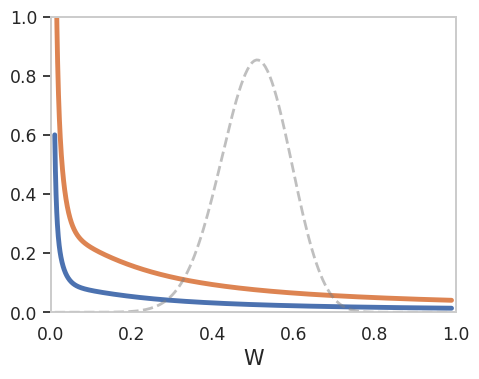

In [25]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
W_dense = np.unique(results['eva_V_50']['W'])
W_sparse = np.unique(results['W'].values)
sns.lineplot(x = W_dense, y = results['eva_V_10']['PiE_NN'][:,0], ax = ax)
sns.lineplot(x = W_dense, y = results['eva_V_90']['PiE_NN'][:,0], ax = ax)
ax2 = ax.twinx()
sns.lineplot(x = W_sparse, y = results['dentW'].values, ax = ax2, ls='--', color='grey',lw=2.0, alpha=0.5)
ax2.grid(False)
ax2.set_yticks([])
ax2.set_ylim([0,0.03])

ax.set_xlim(0,1.0)
ax.grid(False)
ax.set_ylim([0.0,1.0])
ax.set_xlabel('W', fontsize=15)

plt.tight_layout()


## 4.4 Finite Difference Method
We employ a finite differences method from `mfrSuite` to solve Model IP from Section 5, which we cover briefly here.

In [ ]:
import mfr.modelSoln as m
import numpy as np
import argparse
import os
import sys
import warnings
warnings.filterwarnings("ignore")

The model inputs are identical to the neural network solution above, except that: we abstract away from $Z^2$; we have to set $dt$ as our false-transient time-step; and some inputs have been moved inside the `main_solve.py` script.

In [ ]:
chiUnderline = 1.0
a_e=0.0922
a_h=0.0
gamma_e = 4.0
gamma_h=4.0
delta_e=0.0115
delta_h=0.01
lambda_d=0.0
rho_e=1.0
rho_h=1.0
nu=0.1
dt = 0.1
nWealth=180
nZ=30
shock_expo = 'upper_triangular'
